# MLP

Non-coding. Use one neuron and selected K-mers.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-20 18:14:54.534526
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization
from sklearn.preprocessing import StandardScaler

dt='float32'
tf.keras.backend.set_floatx(dt)

tf.random.set_seed(42) # reproducible training sessions?

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=20
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_noncoding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_noncoding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp = keras.models.Sequential()
    one_layer = keras.layers.Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
      
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-20 18:15:03.730061
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2022-10-20 18:15:03.734396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-20 18:15:03.880548
Loaded values for cell line 0
Selected 1422 values out of 4622
2022-10-20 18:15:04.887413


## Train and validate with all K-mer counts

splitting
2022-10-20 18:15:04.917856
Train sizes 1477 1477
Valid sizes 340 340
scaling
2022-10-20 18:15:04.943921
Thresholds (-2.0908811911882577, 1.1671038970933545)
Train set ones/size 1033 / 1477
Valid set ones/size 190 / 340
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-20 18:15:04.969631
Epoch 1/20
47/47 [==============================] - 1s 6ms/step - loss: 0.7663 - accuracy: 0.5531 - val_loss: 0.6907 - val_accuracy: 0.6059
Epoch 2/20
47/47 [==============================] - 0s 3ms/step - loss: 0.5978 - accuracy: 0.6804 - val_loss: 0.7009 - val_accuracy: 0.6088
Epoch 3/20
47/47 [==============================] - 0s 6ms/step - loss: 0.5639 - accuracy: 0.7373 - val_loss: 0.7160 - val_accuracy: 0.6176
Epoch 4/20
47/47 [==============================] - 0s 4ms/step - loss: 0.5415 - accuracy: 0.7454 - val_loss: 0.7332 - val_accuracy: 0.6059
Epoch 5/20
47/47 [==============================] - 0s 4ms/step - loss: 0.5248 - accuracy: 0.7583 - val_loss: 0.7467 - val_accuracy: 0.6088
Epoch

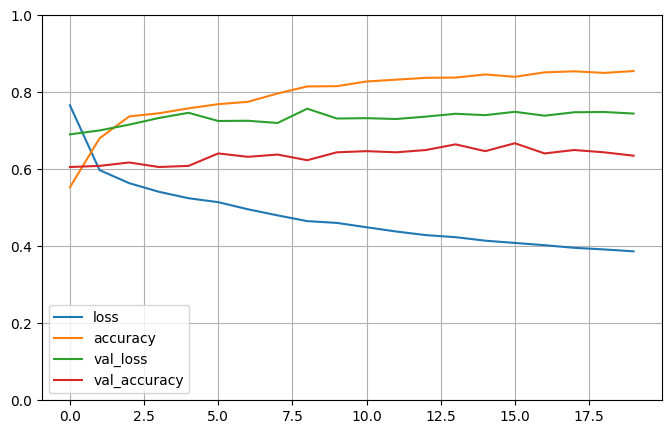

Compute valiation accuracy
2022-10-20 18:15:09.950509
accuracy: 63.53%
2022-10-20 18:15:10.071587


In [8]:
print('splitting')
print(datetime.now())
data_partitions = splitter.get_train_valid_partitions(universe)
one_partition =data_partitions[0]
train_genes,valid_genes = one_partition[0],one_partition[1]
thresholds = splitter.choose_thresholds(train_genes,'one_z')
X_train,y_train,train_ids = splitter.get_X_y(train_genes, thresholds)
X_valid,y_valid,valid_ids = splitter.get_X_y(valid_genes, thresholds)
print('Train sizes',len(X_train),len(y_train))
print('Valid sizes',len(X_valid),len(y_valid))

print('scaling')
print(datetime.now())
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

print('Thresholds',thresholds)
print('Train set ones/size',
      np.count_nonzero(y_train),'/',len(y_train))
print('Valid set ones/size',
      np.count_nonzero(y_valid),'/',len(y_valid))

print("BUILD MODEL")
model=build_model()

print("FIT")
print(datetime.now())
history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
        epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
        validation_data=(X_valid,y_valid) )

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

print("Compute valiation accuracy")
print(datetime.now())
scores = model.evaluate(X_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print(datetime.now())

In [9]:
# https://www.tensorflow.org/guide/variable
w=model.trainable_weights[0].numpy()  # weights
b=model.trainable_weights[1].numpy()  # bias
print('bias',b)
print(len(w),'weights min=',min(w),'max=',max(w))

bias [0.61874974]
256 weights min= [-0.24891624] max= [0.24013878]
